#  Movie Rating Prediction Project
This project includes EDA, feature engineering, multiple regression models, tuning, and interpretation.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [39]:
data = pd.read_csv('movies_advanced.csv')
data.head()

,genre,duration,cast_popularity,director_experience,budget_million_usd,language,release_season,marketing_million_usd,sequel,rating
0,Romance,105,8.097348,15,59.147924,English,Off-Season,36.872272,0,4.826266
1,Comedy,128,5.776030,24,219.472134,English,Summer,1.275082,0,4.171289
2,Fantasy,130,3.912312,13,162.440027,Spanish,Winter,1.683260,1,4.040068
3,Thriller,126,5.285974,24,193.963216,Spanish,Summer,7.957661,0,3.434951
4,Thriller,122,9.154880,17,52.484291,Hindi,Off-Season,47.097955,1,5.499569


##  Exploratory Data Analysis

          duration  cast_popularity  director_experience  budget_million_usd  \
count  1500.000000      1500.000000          1500.000000         1500.000000   
mean    123.966667         5.559127            17.416000          128.584236   
std      18.033479         2.588470             9.647365           71.964205   
min      66.000000         1.005199             1.000000            5.039937   
25%     112.000000         3.288710             9.000000           65.142379   
50%     124.000000         5.521321            18.000000          128.506495   
75%     136.000000         7.798125            26.000000          192.925606   
max     192.000000         9.993965            34.000000          249.740246   

       marketing_million_usd       sequel       rating  
count            1500.000000  1500.000000  1500.000000  
mean               25.607835     0.303333     4.092948  
std                14.218698     0.459851     1.128714  
min                 1.028528     0.000000     1.000

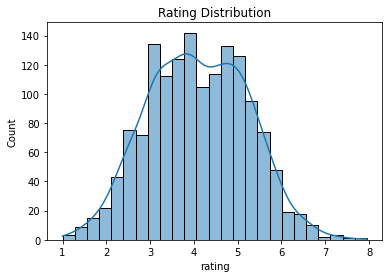

In [40]:
print(data.describe())
plt.figure(figsize=(6,4))
sns.histplot(data['rating'], bins=25, kde=True)
plt.title('Rating Distribution')
plt.show()

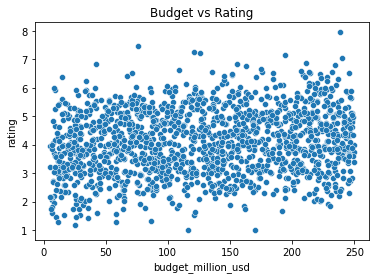

In [41]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='budget_million_usd', y='rating', data=data)
plt.title('Budget vs Rating')
plt.show()

##  Feature Engineering

In [42]:
data['budget_per_minute'] = data['budget_million_usd'] / data['duration']
data['experience_squared'] = data['director_experience'] ** 2
data.head()

,genre,duration,cast_popularity,director_experience,budget_million_usd,language,release_season,marketing_million_usd,sequel,rating,budget_per_minute,experience_squared
0,Romance,105,8.097348,15,59.147924,English,Off-Season,36.872272,0,4.826266,0.563314,225
1,Comedy,128,5.776030,24,219.472134,English,Summer,1.275082,0,4.171289,1.714626,576
2,Fantasy,130,3.912312,13,162.440027,Spanish,Winter,1.683260,1,4.040068,1.249539,169
3,Thriller,126,5.285974,24,193.963216,Spanish,Summer,7.957661,0,3.434951,1.539391,576
4,Thriller,122,9.154880,17,52.484291,Hindi,Off-Season,47.097955,1,5.499569,0.430199,289


In [43]:
X = data.drop('rating', axis=1)
y = data['rating']

cat_cols = ['genre','language','release_season']
num_cols = [col for col in X.columns if col not in cat_cols]

##  Preprocessing Pipeline

In [44]:
num_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])
cat_pipe = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

## Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Model Training

In [46]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    results[name] = scores.mean()

results

{'Ridge': 0.7070667522650729,
 'Lasso': -0.0006819714464212812,
 'RandomForest': 0.6878707444884496,
 'GradientBoosting': 0.687541276804106}

## Hyperparameter Tuning (Gradient Boosting)

In [47]:
gbr_pipe = Pipeline([('prep', preprocess), ('model', GradientBoostingRegressor(random_state=42))])
param_grid = {
    'model__n_estimators':[100,200],
    'model__learning_rate':[0.05,0.1],
    'model__max_depth':[2,3]
}
grid = GridSearchCV(gbr_pipe, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
pred = best_model.predict(X_test)

##  Evaluation Metrics

In [48]:
print('R2:', r2_score(y_test, pred))
print('MAE:', mean_absolute_error(y_test, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))

R2: 0.6886972743380311
MAE: 0.5234368069183003
RMSE: 0.6299674479596303


##  Residual Analysis

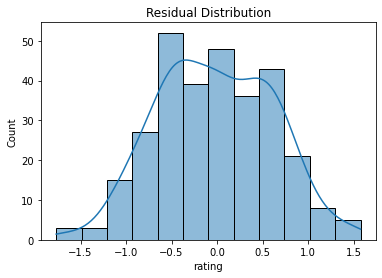

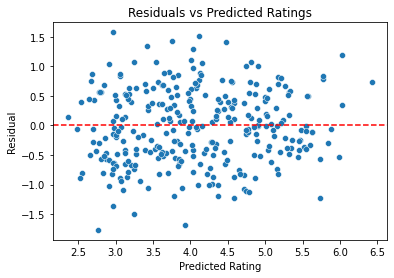

In [49]:
residuals = y_test - pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()


plt.figure(figsize=(6,4))
sns.scatterplot(x=pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Ratings")
plt.xlabel("Predicted Rating")
plt.ylabel("Residual")
plt.show()

##  Feature Importance

In [50]:
feature_names_num = best_model.named_steps['prep'].named_transformers_['num'].named_steps['poly'].get_feature_names_out(num_cols)
feature_names_cat = best_model.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = list(feature_names_num) + list(feature_names_cat)
importances = best_model.named_steps['model'].feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
feat_imp.head(15)

,Feature,Importance
1,cast_popularity,0.752223
16,cast_popularity^2,0.074988
4,marketing_million_usd,0.046806
3,budget_million_usd,0.027669
19,cast_popularity marketing_million_usd,0.019498
6,budget_per_minute,0.011232
18,cast_popularity budget_million_usd,0.008470
21,cast_popularity budget_per_minute,0.007772
2,director_experience,0.006322
20,cast_popularity sequel,0.004360


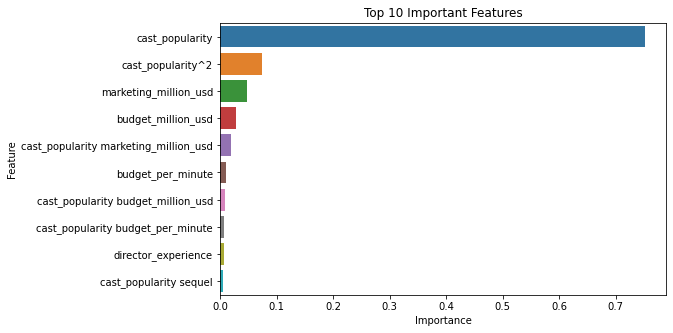

In [51]:
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Important Features")
plt.show()

##  Predict Rating for a New Movie

In [52]:
new_movie = pd.DataFrame({
 'genre':['Action'], 'duration':[130], 'cast_popularity':[8.5], 'director_experience':[15],
 'budget_million_usd':[120], 'language':['English'], 'release_season':['Summer'],
 'marketing_million_usd':[30], 'sequel':[1], 'budget_per_minute':[120/130], 'experience_squared':[15**2]
})
print('Predicted Rating:', best_model.predict(new_movie)[0])

Predicted Rating: 5.223227487934729
